# COVID-19 Radiography Dataset Processing
---

## 📦 Imports and Setup

- `kagglehub`: For downloading datasets from Kaggle.
- `shutil`: Utilities for file operations like copying and removing files.
- `pathlib.Path`: For handling filesystem paths in a platform-independent way.
- `splitfolders`: To split datasets into train, validation, and test folders.
- `os`: Operating system utilities for directory and file management.
- `tensorflow.keras.preprocessing.image`: For image loading and augmentation.
- `utils.display_data_distribution`: Custom utility function to visualize data distribution.


In [ ]:
import kagglehub
import shutil
from pathlib import Path
import splitfolders
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from utils import display_data_distribution


----

## 📂 Dataset Downloader

This script downloads and prepares the **COVID-19 Radiography Database** for training a COVID detector model.  
It retrieves the dataset from Kaggle, organizes the images by class, and saves them in a structured directory:

1. Download the dataset from Kaggle using `kagglehub.dataset_download`.
2. Set the `DATA_DIR` variable to your desired storage location:
   - Leave it empty to use the current working directory.
   - In Google Colab, mount Google Drive and set the path accordingly.
3. The script will copy images into a new folder named `data_for_split` with the following structure:

```bash
   data_for_split/
         ├── COVID/
         ├── Normal/
         ├── Lung_Opacity/
         └── Viral Pneumonia/


In [ ]:
# Download dataset
src_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
print("Original path:", src_path)

In [ ]:
DATA_DIR = "" # Change this to your local path or Google Drive mount path if running in Colab !!!
              # if you keep DATA_DIR = "" , the data will be loaded in your current repo !!

with open('Shared_vars.py', 'w') as f:
    f.write(f"DATA_DIR=\"{DATA_DIR}\"\n")

In [ ]:
# Paths
source_root = Path(src_path+'/COVID-19_Radiography_Dataset')
target_root = Path(DATA_DIR + "/data_for_split")

# Class folders
classes = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]

# Create image-only dataset
for cls in classes:
    source = source_root / cls / "images"
    target = target_root / cls
    target.mkdir(parents=True, exist_ok=True)

    for file in source.glob("*.*"):
        shutil.copy(file, target)

print("✅ Images copied successfully to", target_root)


---

## ⚖️ Split into train, validation, and test sets

The dataset is split using a ratio of:
- 70% for training
- 20% for validation
- 10% for testing
- The final structure will be:


    dataset/
        ├── train/
        │     ├── COVID/
        │     ├── Normal/
        │     ├── Lung_Opacity/
        │     └── Viral Pneumonia/
        ├── val/
        │     ├── COVID/
        │     ├── Normal/
        │     ├── Lung_Opacity/
        │     └── Viral Pneumonia/
        └── test/
              ├── COVID/
              ├── Normal/
              ├── Lung_Opacity/
              └── Viral Pneumonia/

In [ ]:
base_dir = f"{DATA_DIR}/dataset"

splitfolders.ratio(
    f"{DATA_DIR}/data_for_split",
    output=base_dir,
    seed=42,
    ratio=(.7, .2, .1),  # train, val, test
    group_prefix=None  # Only needed for paired data like images + masks
)

---

## 📊 View Training Data Distribution

After splitting the dataset, you can check the distribution of images across classes in the training set.  
This helps ensure the dataset is balanced before starting model training.

/content/utils.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  df = df.sort_values(by='Count', ascending=False)


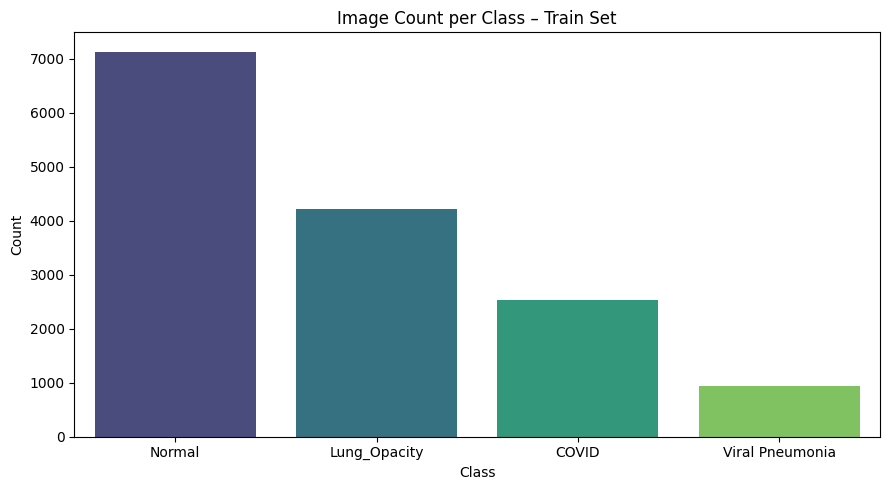

In [10]:
train_dir = base_dir + "/train"
display_data_distribution(train_dir)  # Display the distribution of images across classes in the training set

**Observation:** There is significant class imbalance in the training set. We will address this with data augmentation in the next step.


---

## 📈 Data Augmentation

To increase dataset diversity and improve model generalization, **data augmentation** is applied to selected classes.  

#### 📂 Augmentation Process
- All original images from the training set are copied into a new folder: **train_augmented**.  
- The classes **COVID**, **Lung_Opacity**, and **Viral Pneumonia** are augmented to balance the dataset.  
- For each original image in these classes, **3 augmented versions** are generated.  

#### 📊 Example Output
After augmentation, the new class distribution in the training set is displayed, helping verify dataset balance before training.  


/content/utils.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  df = df.sort_values(by='Count', ascending=False)


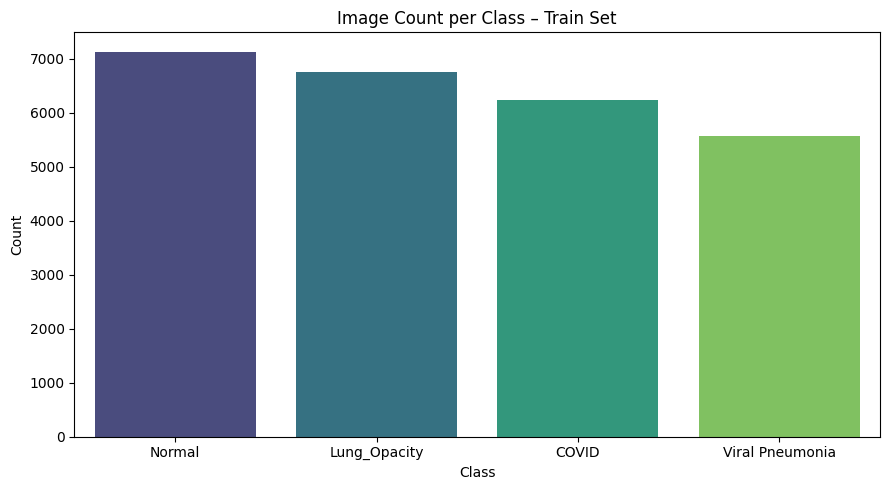

In [12]:
aug_dir = base_dir + "/train_augmented"

classes_to_augment = ['COVID', 'Lung_Opacity', 'Viral Pneumonia']

# Create augmentation generator
augmenter = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Copy all original images to the new folder
for cls in os.listdir(train_dir):
    src = os.path.join(train_dir, cls)
    dst = os.path.join(aug_dir, cls)
    os.makedirs(dst, exist_ok=True)

    for img_name in os.listdir(src):
        shutil.copy(os.path.join(src, img_name), os.path.join(dst, img_name))

        # Augment only if class is in the selected list
        if cls in classes_to_augment:
            img = load_img(os.path.join(src, img_name))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Create 3 augmented versions
            for i, batch in enumerate(augmenter.flow(x, batch_size=1,
                                                     save_to_dir=dst,
                                                     save_prefix='aug',
                                                     save_format='jpeg')):
                if i >= 3:
                    break

display_data_distribution(aug_dir) # Display augmented data distribution